In [40]:
# Importing Libraries
from datasets import load_dataset
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import accuracy_score
from enum import Enum
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
from typing import List


# Use GPU if available
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [41]:
dataset = load_dataset("multi_woz_v22")
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

No config specified, defaulting to: multi_woz_v22/v2.2_active_only
Found cached dataset multi_woz_v22 (C:/Users/berna/.cache/huggingface/datasets/multi_woz_v22/v2.2_active_only/2.2.0/6719c8b21478299411a0c6fdb7137c3ebab2e6425129af831687fb7851c69eb5)


  0%|          | 0/3 [00:00<?, ?it/s]

In [42]:
def filterDomains(data):
    
    return [entry for entry in data if set(entry["services"]).issubset({"restaurant", "hotel", "booking"}) and len(entry["services"]) == 1]
# Only keep dialogues related to Restaurants or Hotels.

train_data_filtered = filterDomains(train_data)
val_data_filtered = filterDomains(val_data)
test_data_filtered = filterDomains(test_data)

In [43]:
def add_data_to_be_retrieved(dataset, print_dialogue=False):
    """
    Augment the dataset with the following information:
    - Information to be retrieved (ground truth)
    
    Heavily inspired by the code from the evaluation script.
    """
    
    for dialogue in dataset:
        turns = dialogue["turns"]
        turns["to_be_retrieved_ground_truth"] = {turn_id: [] for turn_id in range(len(turns["turn_id"]))}
        
        
        for turn_id, _ in enumerate(turns["turn_id"]):
            # If it is SYSTEM turn:
            if turns["speaker"][turn_id]:
                slot_names_per_act = [slot['slot_name'] for slot in turns['dialogue_acts'][turn_id]['dialog_act']['act_slots']]
                slot_values_per_act = [slot['slot_value'] for slot in turns['dialogue_acts'][turn_id]['dialog_act']['act_slots']]
                dialogue_acts = turns['dialogue_acts'][turn_id]['dialog_act']['act_type']
                services = turns['frames'][turn_id]['service']
                current_booking_service = [service for service in services if service in ["hotel", "restaurant"]]

                to_be_retrieved_ground_truth = []
                for act_i in range(len(slot_names_per_act)):
                    domain = dialogue_acts[act_i].split("-")[0].lower()
                    if domain == "booking" and len(current_booking_service) ==1:
                        domain = current_booking_service[0]
                    slot_names = [domain+"-"+slot_names_per_act[act_i][slot_i] for slot_i in range(len(slot_names_per_act[act_i]))
                                    if slot_values_per_act[act_i][slot_i]!="?" and slot_names_per_act[act_i][slot_i]!="none"]
                    if slot_names:
                        to_be_retrieved_slot_names = ["%s-availability" % (domain)] + slot_names
                        while domain+"-choice" in to_be_retrieved_slot_names:
                            del to_be_retrieved_slot_names[to_be_retrieved_slot_names.index(domain+"-choice")]
                        to_be_retrieved_ground_truth.extend(to_be_retrieved_slot_names)
                to_be_retrieved_ground_truth = sorted(list(set(to_be_retrieved_ground_truth)))
                
                # augment the dataset
                turns["to_be_retrieved_ground_truth"][turn_id].extend(to_be_retrieved_ground_truth)
                
                if print_dialogue:
                    print(f"Utterance: {turns['utterance'][turn_id]}")
                    print(f"To be retrieved: {to_be_retrieved_ground_truth}")
        if print_dialogue:        
            print("-"*50)
                       

In [44]:
def add_data_to_be_provided(dataset):
    """
    Augment the dataset with the following information:
    - Information to be provided (ground truth)
    
    Heavily inspired by the code from the evaluation script.
    """
    for dialogue in dataset:
        turns = dialogue["turns"]
        turns["to_be_provided_overall"] = {turn_id: [] for turn_id in range(len(turns["turn_id"]))}
        
        
        for turn_id, _ in enumerate(turns["turn_id"]):
            # If it is SYSTEM turn:
            if turns["speaker"][turn_id]:
                slot_names_per_act = [slot['slot_name'] for slot in turns['dialogue_acts'][turn_id]['dialog_act']['act_slots']]
                slot_values_per_act = [slot['slot_value'] for slot in turns['dialogue_acts'][turn_id]['dialog_act']['act_slots']]
                dialogue_acts = turns['dialogue_acts'][turn_id]['dialog_act']['act_type']
                services = turns['frames'][turn_id]['service']
                current_booking_service = [service for service in services if service in ["hotel", "restaurant"]]
                to_be_provided_overall = []
                
                for act_i in range(len(slot_names_per_act)):
                    domain = dialogue_acts[act_i].split("-")[0].lower()
                    if domain == "booking" and len(current_booking_service)==1:
                        domain = current_booking_service[0]
                    if domain in ["hotel", "restaurant", "booking", "general"]:
                        slot_names_vlues = [domain+"-"+slot_names_per_act[act_i][slot_i]+":"+slot_values_per_act[act_i][slot_i] for slot_i in range(len(slot_names_per_act[act_i]))
                                            if slot_values_per_act[act_i][slot_i]!="?" and slot_names_per_act[act_i][slot_i]!="none"]
                        if slot_names_vlues and any((slot_name_value.split(":")[0]!=domain+"-none" for slot_name_value in slot_names_vlues)) and not "-No" in dialogue_acts[act_i]:
                            to_be_provided = ["%s-availability:yes" % (domain)] + slot_names_vlues
                            to_be_provided_overall.extend(to_be_provided)
                        elif "-No" in dialogue_acts[act_i]:
                            to_be_provided = ["%s-availability:no" % (domain)] + slot_names_vlues
                            to_be_provided_overall.extend(to_be_provided)
                to_be_provided_overall = sorted(list(set(to_be_provided_overall)))
                remove_avail_no_list = [elem for elem in to_be_provided_overall if elem.endswith("availability:no")]
                for remove_avail in remove_avail_no_list:
                    remove_avail_yes = remove_avail[:-2]+"yes"
                    while remove_avail_yes in to_be_provided_overall:
                        del to_be_provided_overall[to_be_provided_overall.index(remove_avail_yes)]
                turns["to_be_provided_overall"][turn_id].extend(to_be_provided_overall)

In [45]:
add_data_to_be_provided(train_data_filtered)
add_data_to_be_retrieved(train_data_filtered)

In [46]:

for turn_id in range(10):
    print(train_data_filtered[turn_id]["turns"]["utterance"][1])
    print("To be provided: ")
    print(train_data_filtered[turn_id]["turns"]["to_be_provided_overall"][1])
    print("To be retrieved: ")
    print(train_data_filtered[turn_id]["turns"]["to_be_retrieved_ground_truth"][1])
    print("-"*50)

I have 4 different options for you. I have two cheaper guesthouses and two expensive hotels. Do you have a preference?
To be provided: 
['hotel-availability:yes', 'hotel-choice:4', 'hotel-pricerange:cheaper', 'hotel-pricerange:expensive', 'hotel-type:guesthouses', 'hotel-type:hotels']
To be retrieved: 
['hotel-availability', 'hotel-pricerange', 'hotel-type']
--------------------------------------------------
I've heard good things about the lucky star. Need a reservation?
To be provided: 
['restaurant-availability:yes', 'restaurant-name:the lucky star']
To be retrieved: 
['restaurant-availability', 'restaurant-name']
--------------------------------------------------
Eraina is a European restaurant in the centre area. Their address is St. Michael's Church Trinity Street City Centre and phone number 01223 355166.
To be provided: 
["restaurant-address:St. Michael's Church Trinity Street City Centre", 'restaurant-area:centre', 'restaurant-availability:yes', 'restaurant-food:European', 're

# 1. Predict what shall be retrieved

#### Idea: Predict what the agent should retrieve based on the user utterance, dialogue act and the previous agent utterance.
    

# 2. Predict dialogue acts of the agent

#### We can and should use the results of the retrieval, i.e. use slots which we requested at the first step and their values (including "yes/no" for the availability slot)

In [47]:
# Add the same information to the validation and test sets
add_data_to_be_provided(val_data_filtered)
add_data_to_be_retrieved(val_data_filtered)

add_data_to_be_provided(test_data_filtered)
add_data_to_be_retrieved(test_data_filtered)

In [48]:
# To predict the dialogue acts of the Agent, we need the utterance of the user in the previous turn, the dialogue acts of the user in the previous turn,
# the utterance of the agent in the previous turn (if available), and the ground truth of the retrieval for the slot and value to be sent to the user.

speaker_str = {0: 'User', 1: 'Agent'}
PAST_HISTORY_LENGTH = 1

# From an array of dialogue acts, remove the dialog act for the domain if it is not one of the four domains
def filter_dialog_acts(dialogue_acts: List[str]):
    dialogue_acts_new = []
    for dialogue_act in dialogue_acts:
        if dialogue_act.split('-')[0].upper() in ['RESTAURANT', 'HOTEL', 'BOOKING', 'GENERAL']:
            dialogue_acts_new.append(dialogue_act)

    return dialogue_acts_new

# From an array of to be retrieved slots, remove the slot act for the domain if it is not one of the four domains
def filter_retrieved_slots(to_be_retrieved_array: List[str]):
    to_be_retrieved_new = []
    for to_be_retrieved in to_be_retrieved_array:
        if to_be_retrieved.split('-')[0].upper() in ['RESTAURANT', 'HOTEL', 'BOOKING', 'GENERAL']:
            to_be_retrieved_new.append(to_be_retrieved)

    return to_be_retrieved_new

def toDataFrame(raw_data):
    # Initialize an empty list to store rows as dictionaries
    data = []

    # Loop through each dialogue in the training data
    for dialogue in raw_data:

        # Get the number of turns in this dialogue
        num_turns = len(dialogue['turns']['utterance'])

        # Initialize the history of the user and agent as lists with ("", []) for the number of PAST_HISTORY_LENGTH elements
        previous_user_history = [("",[]) for i in range(PAST_HISTORY_LENGTH)]
        previous_agent_history = [("",[]) for i in range(PAST_HISTORY_LENGTH)]

        # Loop through each turn in the dialogue
        for i in range(num_turns):
            speaker = speaker_str[dialogue['turns']['speaker'][i]]

            # Extract the utterance and corresponding dialog act for this turn
            utterance = dialogue['turns']['utterance'][i]
            dialogue_act = dialogue['turns']['dialogue_acts'][i]['dialog_act']['act_type']

            # Filter the dialogue acts
            dialogue_act = filter_dialog_acts(dialogue_act.copy())
            
            if speaker == 'User':
                previous_user_history.append((utterance, dialogue_act))
                if len(previous_user_history) > PAST_HISTORY_LENGTH:
                    previous_user_history.pop(0)
            elif speaker == 'Agent':
                # Encode the history of the user and agent as a string
                encoded_history = ""
                for j in range(len(previous_user_history)):
                    encoded_history += ">".join([previous_user_history[j][0], "_".join(previous_user_history[j][1])]) + "|"
                for j in range(len(previous_agent_history)):
                    encoded_history += ">".join([previous_agent_history[j][0], "_".join(previous_agent_history[j][1])]) + "|"

                # Add the to be provided ground truth to the encoded history for this turn
                to_be_provided = filter_retrieved_slots(dialogue['turns']['to_be_retrieved_ground_truth'][i])
                encoded_history = encoded_history + "_".join(to_be_provided) 

                # Append as a dictionary to the data list
                data.append({'EncodedHistory': encoded_history, 'DialogueAct': dialogue_act})

                previous_agent_history.append((utterance, dialogue_act))
                if len(previous_agent_history) > PAST_HISTORY_LENGTH:
                    previous_agent_history.pop(0)

    # Save data as pandas df
    df = pd.DataFrame(data)

    # Separate features and labels
    X = df['EncodedHistory']
    Y = df['DialogueAct']
    
    return X, Y
        
X_train, Y_train = toDataFrame(train_data_filtered)
X_val, Y_val = toDataFrame(val_data_filtered)
X_test, Y_test = toDataFrame(test_data_filtered)

# Final Training
X_test_val = pd.concat([X_test,X_val])
Y_test_val = pd.concat([Y_test, Y_val])

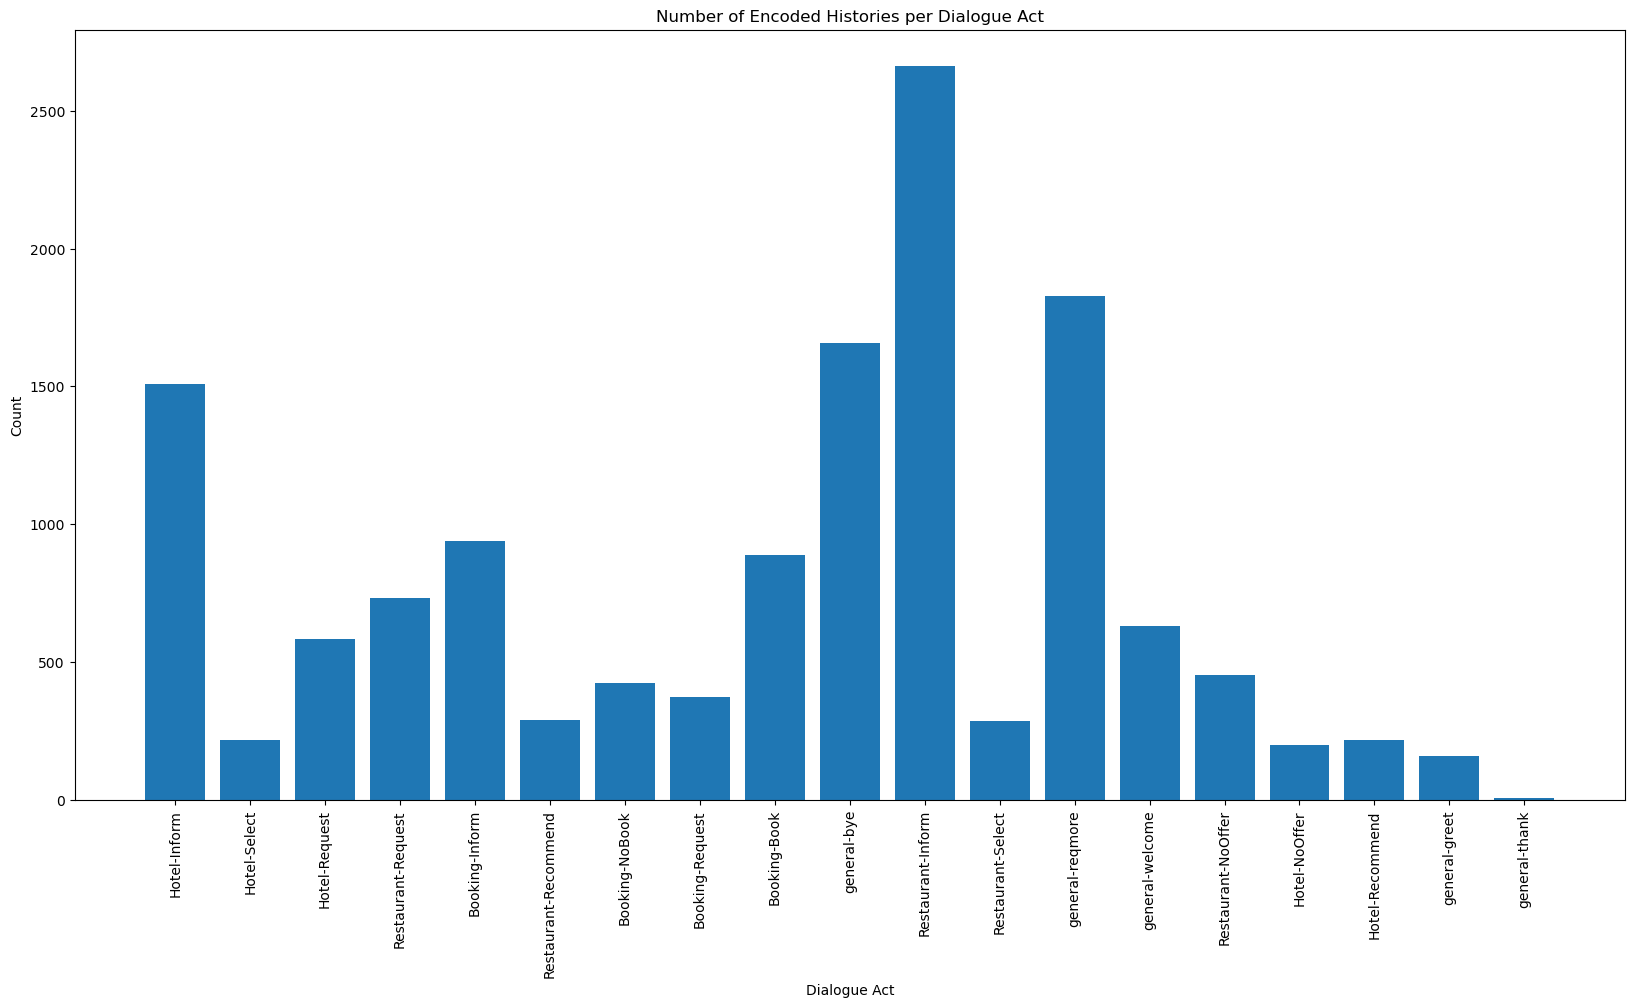

[('general-thank', 7), ('general-greet', 158), ('Hotel-NoOffer', 199), ('Hotel-Recommend', 217), ('Hotel-Select', 218), ('Restaurant-Select', 286), ('Restaurant-Recommend', 291), ('Booking-Request', 372), ('Booking-NoBook', 424), ('Restaurant-NoOffer', 451)]


In [49]:
# Generate a histogram of the number of Encoded History per dialogue act, knowing that there can be multiple dialogue acts per Encoded History. 
# To deal with this, we count as a separate Encoded Historyistory each time a dialogue act is present in an Encoded History, instead of counting more than one
# dialogue act per Encoded History.

# Initialize an empty dictionary to store the counts of each dialogue act
counts = {}

# Loop through each dialogue act array in the training data

for dialogue_act_array in Y_train:
        # Loop through each dialogue act in the dialogue act array
        for dialogue_act in dialogue_act_array:
            
            # If the dialogue act is already in the dictionary, increment its count by 1
            if dialogue_act in counts:
                counts[dialogue_act] += 1
            
            # If the dialogue act is not already in the dictionary, set its count to 1
            else:
                counts[dialogue_act] = 1

# Plot the histogram
plt.figure(figsize=(20, 10))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=90)
plt.xlabel('Dialogue Act')
plt.ylabel('Count')
plt.title('Number of Encoded Histories per Dialogue Act')
plt.show()

# Bottom 10 dialogue acts
sorted_counts = sorted(counts.items(), key=lambda item: item[1])
print(sorted_counts[:10])



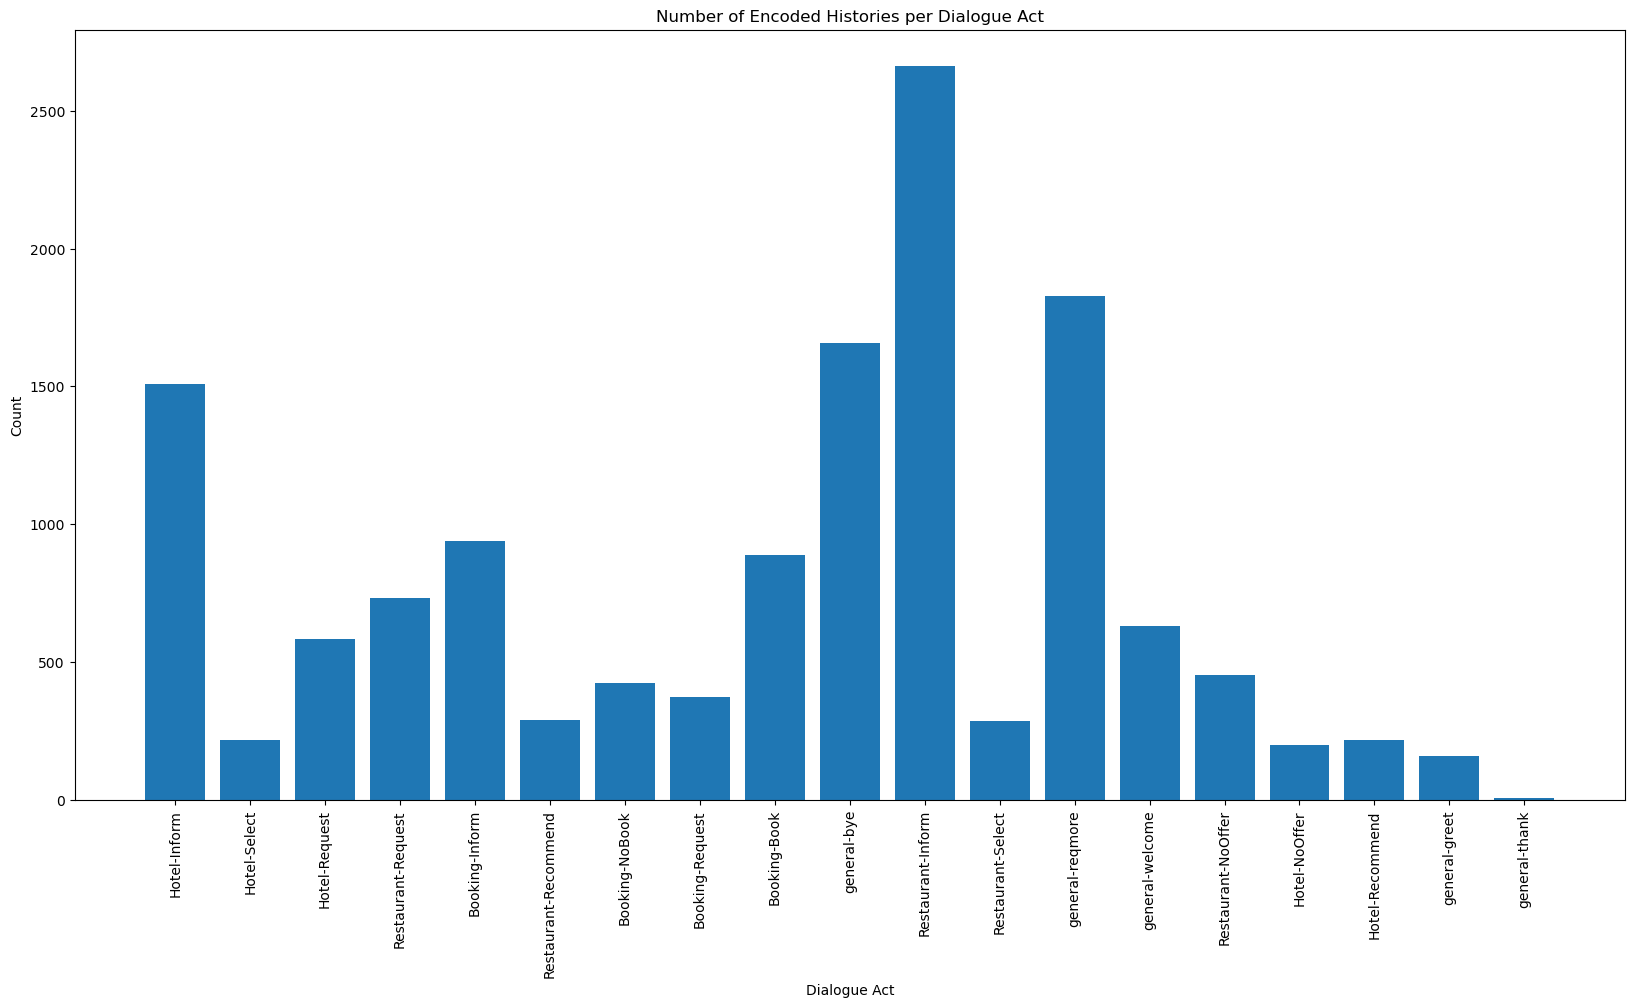

In [50]:
def prune_empty_dialogue_acts(X, Y):
    """
    Prunes the data to exclude Encoded Histories with no dialogue acts.

    Parameters:
    - X: list of Encoded Histories.
    - Y: list of lists of dialogue acts.

    Returns:
    - relabelled lists of Encoded Histories and dialogue acts.
    """
    # Initialize empty lists to store the pruned data
    X_pruned = []
    Y_pruned = []

    # Loop through each Encoded History and corresponding dialogue act array in the data
    for encoded_history, dialogue_act_array in zip(X, Y):

        # If the dialogue act array is not empty, append the Encoded History and dialogue act array to the pruned data
        if len(dialogue_act_array) > 0:
            X_pruned.append(encoded_history)
            Y_pruned.append(dialogue_act_array)
    
    return X_pruned, Y_pruned

# Prune empty dialogue acts for training, validation, and test data
X_pruned_train, Y_pruned_train = prune_empty_dialogue_acts(X_train, Y_train)
X_pruned_val, Y_pruned_val = prune_empty_dialogue_acts(X_val, Y_val)
X_pruned_test, Y_pruned_test = prune_empty_dialogue_acts(X_test, Y_test)
X_pruned_test_val, Y_pruned_test_val = prune_empty_dialogue_acts(X_test_val, Y_test_val)

# Generate a histogram of the number of Encoded Histories per dialogue act, knowing that there can be multiple dialogue acts per Encoded History.
# To deal with this, we count as a separate Encoded History each time a dialogue act is present in an Encoded History, instead of counting more than one
# dialogue act per Encoded History.

# Initialize an empty dictionary to store the counts of each dialogue act
counts = {}

# Loop through each dialogue act array in the training data

for dialogue_act_array in Y_pruned_train:
    # Loop through each dialogue act in the dialogue act array
    for dialogue_act in dialogue_act_array:
        
        # If the dialogue act is already in the dictionary, increment its count by 1
        if dialogue_act in counts:
            counts[dialogue_act] += 1
        
        # If the dialogue act is not already in the dictionary, set its count to 1
        else:
            counts[dialogue_act] = 1

# Plot the histogram
plt.figure(figsize=(20, 10))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=90)
plt.xlabel('Dialogue Act')
plt.ylabel('Count')
plt.title('Number of Encoded Histories per Dialogue Act')
plt.show()

In [51]:
from sklearn.preprocessing import MultiLabelBinarizer


# Initialize a MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

# Fit the MultiLabelBinarizer object on the training data
mlb.fit(Y_pruned_train)

# Transform the training, validation, and test data
Y_encoded_train = mlb.transform(Y_pruned_train)
Y_encoded_val = mlb.transform(Y_pruned_val)
Y_encoded_test = mlb.transform(Y_pruned_test)
Y_encoded_test_val = mlb.transform(Y_pruned_test_val)

# Print the shape of the encoded training, validation, and test data
print(Y_encoded_train.shape)
print(Y_encoded_val.shape)
print(Y_encoded_test.shape)
print(Y_encoded_test_val.shape)

# Print the classes
print(mlb.classes_)
# Print the number of classes
print(len(mlb.classes_))

# Print the first 10 encoded training labels
print(Y_encoded_train[:10])

# Print the first 10 decoded training labels
print(mlb.inverse_transform(Y_encoded_train[:10]))

# Dump the MultiLabelBinarizer object to a pickle file
import pickle
pickle.dump(mlb, open('mlb3.2.pkl', 'wb'))

(8942, 19)
(563, 19)
(692, 19)
(1255, 19)
['Booking-Book' 'Booking-Inform' 'Booking-NoBook' 'Booking-Request'
 'Hotel-Inform' 'Hotel-NoOffer' 'Hotel-Recommend' 'Hotel-Request'
 'Hotel-Select' 'Restaurant-Inform' 'Restaurant-NoOffer'
 'Restaurant-Recommend' 'Restaurant-Request' 'Restaurant-Select'
 'general-bye' 'general-greet' 'general-reqmore' 'general-thank'
 'general-welcome']
19
[[0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]
[('Hotel-Inform', 'Hotel-Select'), ('Hotel-Request', 'Restaurant-Request'), ('Booking-Inform', 'Hotel-Inform', 'Restaurant-Recommend'), ('Booking-NoBook', 'Booking-Request'), ('Booking-Book',), ('general

In [52]:
# Bert Models Enumeration
class BertModelsEnum(str, Enum):
    distilbert_base_uncased = 'distilbert-base-uncased'
    distilbert_base_cased = 'distilbert-base-cased'

bert_model_type = BertModelsEnum.distilbert_base_uncased.value
tokenizer = DistilBertTokenizer.from_pretrained(bert_model_type)
def tokenize_data(X, Y):
    input_encoded = []
    attention_masks = []
    labels = []
    for x,y in zip(X,Y):
        # Separate the history from the to be provided with label and value splitting by the last "|" character, but don't remove it
        history, to_be_provided = x.rsplit("|", 1)
        
        # Merge the history and to be provided into a single string adding a [SEP] token between them
        sentence = "".join(history) + " [SEP] " + to_be_provided
        encoded = tokenizer.encode_plus(
            sentence, 
            add_special_tokens=True, 
            max_length=256, 
            padding='max_length', 
            truncation=True, 
            return_attention_mask=True)
        input_encoded.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        labels.append(y)
    return torch.tensor(input_encoded), torch.tensor(attention_masks), torch.tensor(labels)

train_input, train_masks, train_labels = tokenize_data(X_pruned_train, Y_encoded_train)
val_input, val_masks, val_labels = tokenize_data(X_pruned_val, Y_encoded_val)
test_input, test_masks, test_labels = tokenize_data(X_pruned_test, Y_encoded_test)
test_val_input, test_val_masks, test_val_labels = tokenize_data(X_pruned_test_val, Y_encoded_test_val)

C:\Users\berna\AppData\Local\Temp\ipykernel_14864\3791192551.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  return torch.tensor(input_encoded), torch.tensor(attention_masks), torch.tensor(labels)


In [53]:
batch_size = 64 # Adjust based on GPU memory requirements
num_workers = 4 # Adjust based on the number of CPU cores

train_data = TensorDataset(train_input, train_masks, train_labels)
val_data = TensorDataset(val_input, val_masks, val_labels)
test_data = TensorDataset(test_input, test_masks, test_labels)
test_val_data = TensorDataset(test_val_input, test_val_masks, test_val_labels)

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
test_val_loader = DataLoader(test_val_data, batch_size=batch_size, num_workers=num_workers)

class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(bert_model_type)
        self.fc = nn.Linear(768, len(mlb.classes_))

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :] # selects the [CLS] token position.
        logits = torch.sigmoid(self.fc(cls_output))
        return logits

class SaveModelWithBestValLoss:
    """
    Class that saves the best model during a training process. If the current epoch's validation loss 
    is smaller than the previous smallest validation loss saved, it saves the model state.
    The best valid loss is initialized to infinity.
    """
    def __init__(
        self, smallest_valid_loss=float('inf')
    ):
        self.smallest_valid_loss = smallest_valid_loss
        
    def save(
        self, current_valid_loss, epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.smallest_valid_loss:
            self.smallest_valid_loss = current_valid_loss
            print(f"Saving best model for epoch {epoch+1}, with new best validation loss: {self.smallest_valid_loss}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'best_model3.2.pth')

In [54]:
model = BertClassifier()
model = model.to(device)
 
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.BCELoss()

scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=40)

save_best_model_instance = SaveModelWithBestValLoss()

# For storing training and validation loss
train_losses = []
val_losses = []

lrs = []
for epoch in range(40):
    model.train()
    
    # Initialize tqdm progress bar
    #train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch}')
    
    train_loss = 0.0
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels.float())
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
        
        # Update training loss
        train_loss += loss.item()
        #train_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
    # Average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    val_loss = 0.0
    model.eval()

    # Initialize tqdm progress bar for validation
    #val_bar = tqdm(val_loader, desc=f'Validation Epoch {epoch}')
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            
            # Forward pass
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels.float())
            
            val_loss += loss.item()
            #val_bar.set_postfix({'validation_loss': '{:.3f}'.format(loss.item()/len(batch))})
            
    # Average validation loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    if len(val_losses) >= 4:
        diff_val_loss_1 = val_losses[-2] - val_losses[-1]
        diff_val_loss_2 = val_losses[-3] - val_losses[-1]
        diff_val_loss_3 = val_losses[-4] - val_losses[-1]
        if diff_val_loss_3 < 0 and diff_val_loss_2 < 0 and diff_val_loss_1 < 0:
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss} DID NOT IMPROVE')
            break
    
    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
    
    # Save model if validation model loss decreases
    save_best_model_instance.save(
        avg_val_loss, epoch, model, optimizer, criterion
    )

KeyboardInterrupt: 

In [ ]:
# Plotting validation and training loss
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# build the model, without loading the pre-trained weights or fine-tune layers
saved_model = BertClassifier().to(device)
best_model = torch.load('best_model3.2.pth')
saved_model.load_state_dict(best_model['model_state_dict'])

all_preds = []
all_labels = []

# Put the Saved Model in evaluation mode
saved_model.eval()

# Disable gradient computation
with torch.no_grad():
    # Initialize tqdm progress bar for Test
    test_bar = tqdm(test_loader, desc='Test')

    for batch in test_bar:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = saved_model(input_ids, attention_mask)

        # Get the predicted labels
        #_, preds = torch.max(logits, dim=1)

        # Move preds and labels to CPU for further evaluation (if using GPU)
        preds = logits.cpu().numpy()
        labels = labels.cpu().numpy()

        # Extend the list of predictions and labels
        all_preds.extend(preds)
        all_labels.extend(labels)

from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report
import numpy as np
threshold = 0.5
all_preds_binary = []
for all_pred in all_preds:
    local_pred = []
    for old_local_pred in all_pred:
        binary_local_pred = (old_local_pred > threshold).astype(int)
        local_pred.append(binary_local_pred)
    all_preds_binary.append(local_pred)

confusion_matrices = mcm(all_labels, all_preds_binary)
print(classification_report(all_labels, all_preds_binary, target_names=mlb.classes_))

# Plotting
n_labels = confusion_matrices.shape[0]
fig, axes = plt.subplots(n_labels, 1, figsize=(5, 5 * n_labels))

for i, (cm, ax) in enumerate(zip(confusion_matrices, axes)):
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(title=mlb.classes_[i], 
           ylabel='True label',
           xlabel='Predicted label',
           xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=['0', '1'], yticklabels=['0', '1'])

plt.tight_layout()
plt.show()

In [ ]:
# # Final Model
# model = BertClassifier()
# model = model.to(device)
 
# optimizer = optim.Adam(model.parameters(), lr=1e-5)
# criterion = nn.BCELoss()

# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=40)

# save_best_model_instance = SaveModelWithBestValLoss()

# # For storing training and validation loss
# train_losses = []
# val_losses = []

# lrs = []
# for epoch in range(45):
#     model.train()
    
#     # Initialize tqdm progress bar
#     #train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch}')
    
#     train_loss = 0.0
#     for batch in train_loader:
#         input_ids, attention_mask, labels = batch
#         input_ids = input_ids.to(device)
#         attention_mask = attention_mask.to(device)
#         labels = labels.to(device)

        
#         # Zero the parameter gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         logits = model(input_ids, attention_mask)
#         loss = criterion(logits, labels.float())
        
#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
        
#         lrs.append(optimizer.param_groups[0]["lr"])
#         scheduler.step()
        
#         # Update training loss
#         train_loss += loss.item()
#         #train_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
#     # Average training loss
#     avg_train_loss = train_loss / len(train_loader)
#     train_losses.append(avg_train_loss)
    
#     # Validation
#     val_loss = 0.0
#     model.eval()

#     # Initialize tqdm progress bar for validation
#     #val_bar = tqdm(test_val_loader, desc=f'Validation Epoch {epoch}')
    
#     with torch.no_grad():
#         for batch in test_val_loader:
#             input_ids, attention_mask, labels = batch
#             input_ids = input_ids.to(device)
#             attention_mask = attention_mask.to(device)
#             labels = labels.to(device)

            
#             # Forward pass
#             logits = model(input_ids, attention_mask)
#             loss = criterion(logits, labels.float())
            
#             val_loss += loss.item()
#             #val_bar.set_postfix({'validation_loss': '{:.3f}'.format(loss.item()/len(batch))})
            
#     # Average validation loss
#     avg_val_loss = val_loss / len(val_loader)
#     val_losses.append(avg_val_loss)
    
#     if len(val_losses) >= 4:
#         diff_val_loss_1 = val_losses[-2] - val_losses[-1]
#         diff_val_loss_2 = val_losses[-3] - val_losses[-1]
#         diff_val_loss_3 = val_losses[-4] - val_losses[-1]
#         if diff_val_loss_3 < 0 and diff_val_loss_2 < 0 and diff_val_loss_1 < 0:
#             print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss} DID NOT IMPROVE')
#             break
    
    
#     print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
    
#     # Save model if validation model loss decreases
#     save_best_model_instance.save(
#         avg_val_loss, epoch, model, optimizer, criterion
#     )

# import matplotlib.pyplot as plt
# plt.plot(train_losses, label='Training loss')
# plt.plot(val_losses, label='Validation loss')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()

In [ ]:
# # Plotting validation and training loss

# # build the model, without loading the pre-trained weights or fine-tune layers
# saved_model = BertClassifier().to(device)
# best_model = torch.load('best_model3.2.pth', map_location=torch.device(device))
# saved_model.load_state_dict(best_model['model_state_dict'])

# all_preds = []
# all_labels = []

# # Put the Saved Model in evaluation mode
# saved_model.eval()

# # Disable gradient computation
# with torch.no_grad():
#     # Initialize tqdm progress bar for Test
#     test_bar = tqdm(test_val_loader, desc='Test')

#     for batch in test_bar:
#         input_ids, attention_mask, labels = batch
#         input_ids = input_ids.to(device)
#         attention_mask = attention_mask.to(device)
#         labels = labels.to(device)

#         # Forward pass
#         logits = saved_model(input_ids, attention_mask)

#         # Get the predicted labels
#         #_, preds = torch.max(logits, dim=1)

#         # Move preds and labels to CPU for further evaluation (if using GPU)
#         preds = logits.cpu().numpy()
#         labels = labels.cpu().numpy()

#         # Extend the list of predictions and labels
#         all_preds.extend(preds)
#         all_labels.extend(labels)

In [ ]:
# from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report
# import numpy as np
# threshold = 0.5
# all_preds_binary = []
# for all_pred in all_preds:
#     local_pred = []
#     for old_local_pred in all_pred:
#         binary_local_pred = (old_local_pred > threshold).astype(int)
#         local_pred.append(binary_local_pred)
#     all_preds_binary.append(local_pred)

# confusion_matrices = mcm(all_labels, all_preds_binary)
# print(classification_report(all_labels, all_preds_binary, target_names=mlb.classes_))
# acc_score = accuracy_score(all_labels, all_preds_binary)
# print(f"Accuracy (micro): {acc_score}")

# # Plotting
# n_labels = confusion_matrices.shape[0]
# fig, axes = plt.subplots(n_labels, 1, figsize=(5, 5 * n_labels))

# for i, (cm, ax) in enumerate(zip(confusion_matrices, axes)):
#     im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#     ax.figure.colorbar(im, ax=ax)
#     ax.set(title=mlb.classes_[i], 
#            ylabel='True label',
#            xlabel='Predicted label',
#            xticks=np.arange(cm.shape[1]),
#            yticks=np.arange(cm.shape[0]),
#            xticklabels=['0', '1'], yticklabels=['0', '1'])

# plt.tight_layout()
# plt.show()

In [ ]:
# Production Module - @TODO

# 3. Predict what information shall be requested

#### Once again using the results of the retrieval and likely the user's utterance and dialogue act